# SSY340 Project - Trajectory Estimation

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [2]:
# importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.nn.functional import softmax

import utils
import os
import pandas as pd
import numpy as np
import random
import scipy.spatial
import scipy.io
from copy import deepcopy
import math
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import dataloader
# import model
import model_Transformer_modified

## 2. Pre-processing

In [3]:
# defining model save location
save_location = "./Transformer_models_v2"
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# lenght of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12

# creating torch datasets
train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=False)
# test_dataset, _ = create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0)

In [4]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [5]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

## 4. Training

#### 4.1 create a model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model = model_Transformer_modified.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048).to(device)

In [7]:
tf_model

Transformer(
  (encoder_embedding): Embeddings(
    (linear_embd): Linear(in_features=2, out_features=512, bias=True)
  )
  (decoder_embedding): Embeddings(
    (linear_embd): Linear(in_features=3, out_features=512, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (gelu): GELU(approximate='none')
      )
      (norm_input): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm_output): LayerNorm((512

#### 4.2 The training loop

Value of eta max is: 0.0001


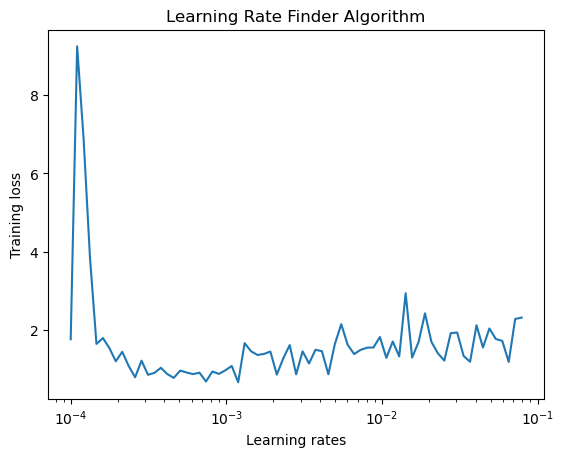

In [8]:
# learning rate finder algorithm for finding eta max

# performing training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating model
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout=0.1

# tf_model = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
#                 num_heads, ff_hidden_size, n, dropout=0.1).to(device)

# number of iterations for LRF
iterations = 70

# creating optimizer
# optimizer = torch.optim.SGD(tf_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.AdamW(tf_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

# calculating the mean and standard deviation of velocities of the entire dataset
mean=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).mean((0,1))
std=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).std((0,1))
means=[]
stds=[]
for i in np.unique(train_dataset[:]['dataset']):
    ind=train_dataset[:]['dataset']==i
    means.append(torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).mean((0, 1)))
    stds.append(
        torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).std((0, 1)))
mean=torch.stack(means).mean(0)
std=torch.stack(stds).mean(0)

train_loss, learning_rates = utils.learning_rate_finder(tf_model, optimizer, train_loader, iterations, device, mean, std)
eta_star = learning_rates[np.argmin(np.array(train_loss))]
eta_max = eta_star/10
print("Value of eta max is: {:.4f}".format(eta_max))

# plotting results
plt.figure()
plt.plot(learning_rates, train_loss)
plt.xlabel("Learning rates")
plt.ylabel("Training loss")
plt.xscale('log')
plt.title("Learning Rate Finder Algorithm")
plt.show()

#### 4.3 Train the model

In [9]:
# training loop

# creating model
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout=0.1

# tf_model = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
#                 num_heads, ff_hidden_size, n, dropout=0.1)
# tf_model = tf_model.to(device)



tf_model = model_Transformer_modified.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048).to(device)

# creating optimizer
# optimizer = torch.optim.SGD(tf_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)
# optimizer = torch.optim.AdamW(tf_model.parameters(), lr=1e-2, betas=(0.9, 0.95), weight_decay=1e-1)

# number of epochs 
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# finding the total number of weight updates for the network
T = epochs * len(train_loader)
# initializing variable to track the number of weight updates
weight_update = 0
# initializing variable to store the changing learning rate
learning_rate = []

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    tf_model.train()
    
    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # changing the learning rate based on cosine scheduler
        lr = utils.cosine_scheduler(weight_update, eta_max, T)
        for param in optimizer.param_groups:
            learning_rate.append(lr)
            param['lr'] = lr
        weight_update += 1

        # getting encoder input data
        enc_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

        # getting decoder input data
        target = (data['trg'][:,:-1,2:4].to(device)-mean.to(device))/std.to(device)
        target_append = torch.zeros((target.shape[0],target.shape[1],1)).to(device)
        target = torch.cat((target,target_append),-1)
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0],1,1).to(device)
        dec_input = torch.cat((start_of_seq, target), 1)

        # getting masks for decoder
        dec_source_mask = torch.ones((enc_input.shape[0], 1,enc_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(dec_input.shape[1]).repeat(dec_input.shape[0],1,1).to(device)

        # forward pass 
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = tf_model.forward(enc_input, dec_input)
        

        # calculating loss using pairwise distance of all predictions
        loss = F.pairwise_distance(predictions[:, :,0:2].contiguous().view(-1, 2),
                                    ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                    contiguous().view(-1, 2).to(device)).mean() + \
                                    torch.mean(torch.abs(predictions[:,:,2]))
        train_batch_loss += loss.item()
        
        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch+1, epochs, training_loss[-1]))


    # validation loop
    if (epoch+1)%5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            tf_model.eval()
            
            # validation variables
            batch_val_loss=0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth 
                gt.append(data['trg'][:, :, 0:2])

                # input to encoder input
                val_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

                # input to decoder
                start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(val_input.shape[0], 1, 1).to(device)
                dec_inp = start_of_seq
                # decoder masks
                dec_source_mask = torch.ones((val_input.shape[0], 1, val_input.shape[1])).to(device)
                dec_target_mask = utils.subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

                # prediction till horizon lenght
                for i in range(horizon):
                    # getting model prediction
                    # model_output = tf_model.forward(val_input, dec_inp, dec_source_mask, dec_target_mask)
                    model_output = tf_model.forward(val_input, dec_inp)
                    
                    # appending the predicition to decoder input for next cycle
                    dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

                # calculating loss using pairwise distance of all predictions
                val_loss = F.pairwise_distance(dec_inp[:,1:,0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                            contiguous().view(-1, 2).to(device)).mean() + \
                                            torch.mean(torch.abs(dec_inp[:,1:,2]))
                batch_val_loss += val_loss.item()

                # calculating the position for each time step of prediction based on velocity
                preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
                    data['src'][:,-1:,0:2].cpu().numpy()

                pr.append(preds_tr_b)
            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(epoch+1, epochs, mad, fad))

    if (epoch+1)%50 == 0:
        # Saving model, loss and error log files
        torch.save({
            'model_state_dict': tf_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'val_mad': val_mad,
            'val_fad':val_fad,
            'learning_rate':learning_rate
            }, os.path.join(save_location, 'raw_cosine_sgd_epoch{}.pth'.format(epoch+1)))
    

  1%|          | 1/100 [00:34<56:36, 34.31s/it]

Epoch 1/100....Training loss = 0.3753


  2%|▏         | 2/100 [01:09<56:47, 34.78s/it]

Epoch 2/100....Training loss = 0.2480


  3%|▎         | 3/100 [01:44<56:43, 35.09s/it]

Epoch 3/100....Training loss = 0.2319


  4%|▍         | 4/100 [02:20<56:30, 35.32s/it]

Epoch 4/100....Training loss = 0.2130
Epoch 5/100....Training loss = 0.2079


  5%|▌         | 5/100 [03:12<1:05:16, 41.23s/it]

Epoch 5/100....Validation mad = 0.5680, Validation fad = 1.1621


  6%|▌         | 6/100 [03:47<1:01:36, 39.32s/it]

Epoch 6/100....Training loss = 0.2073


  7%|▋         | 7/100 [04:23<59:06, 38.13s/it]  

Epoch 7/100....Training loss = 0.2011


  8%|▊         | 8/100 [04:59<57:17, 37.37s/it]

Epoch 8/100....Training loss = 0.2071


  9%|▉         | 9/100 [05:34<55:50, 36.82s/it]

Epoch 9/100....Training loss = 0.1920
Epoch 10/100....Training loss = 0.1847


 10%|█         | 10/100 [06:26<1:02:05, 41.40s/it]

Epoch 10/100....Validation mad = 0.5340, Validation fad = 1.1481


 11%|█         | 11/100 [07:02<58:46, 39.62s/it]  

Epoch 11/100....Training loss = 0.1812


 12%|█▏        | 12/100 [07:37<56:19, 38.40s/it]

Epoch 12/100....Training loss = 0.1791


 13%|█▎        | 13/100 [08:13<54:29, 37.58s/it]

Epoch 13/100....Training loss = 0.1758


 14%|█▍        | 14/100 [08:49<53:02, 37.00s/it]

Epoch 14/100....Training loss = 0.1806
Epoch 15/100....Training loss = 0.1789


 15%|█▌        | 15/100 [09:41<58:47, 41.50s/it]

Epoch 15/100....Validation mad = 0.6801, Validation fad = 1.6272


 16%|█▌        | 16/100 [10:16<55:45, 39.82s/it]

Epoch 16/100....Training loss = 0.1784


 17%|█▋        | 17/100 [10:52<53:27, 38.64s/it]

Epoch 17/100....Training loss = 0.1742


 18%|█▊        | 18/100 [11:28<51:43, 37.84s/it]

Epoch 18/100....Training loss = 0.1757


 19%|█▉        | 19/100 [12:04<50:17, 37.25s/it]

Epoch 19/100....Training loss = 0.1720
Epoch 20/100....Training loss = 0.1725


 20%|██        | 20/100 [12:56<55:38, 41.73s/it]

Epoch 20/100....Validation mad = 0.5345, Validation fad = 1.1996


 21%|██        | 21/100 [13:32<52:37, 39.97s/it]

Epoch 21/100....Training loss = 0.1683


 22%|██▏       | 22/100 [14:08<50:25, 38.79s/it]

Epoch 22/100....Training loss = 0.1690


 23%|██▎       | 23/100 [14:44<48:40, 37.92s/it]

Epoch 23/100....Training loss = 0.1633


 24%|██▍       | 24/100 [15:20<47:15, 37.31s/it]

Epoch 24/100....Training loss = 0.1599
Epoch 25/100....Training loss = 0.1594


 25%|██▌       | 25/100 [16:12<52:09, 41.73s/it]

Epoch 25/100....Validation mad = 0.5230, Validation fad = 1.1529


 26%|██▌       | 26/100 [16:48<49:19, 39.99s/it]

Epoch 26/100....Training loss = 0.1556


 27%|██▋       | 27/100 [17:24<47:11, 38.79s/it]

Epoch 27/100....Training loss = 0.1531


 28%|██▊       | 28/100 [18:00<45:31, 37.94s/it]

Epoch 28/100....Training loss = 0.1513


 29%|██▉       | 29/100 [18:36<44:09, 37.32s/it]

Epoch 29/100....Training loss = 0.1501
Epoch 30/100....Training loss = 0.1474


 30%|███       | 30/100 [19:28<48:41, 41.74s/it]

Epoch 30/100....Validation mad = 0.4485, Validation fad = 0.9768


 31%|███       | 31/100 [20:04<45:59, 40.00s/it]

Epoch 31/100....Training loss = 0.1482


 32%|███▏      | 32/100 [20:40<43:57, 38.79s/it]

Epoch 32/100....Training loss = 0.1428


 33%|███▎      | 33/100 [21:16<42:23, 37.96s/it]

Epoch 33/100....Training loss = 0.1461


 34%|███▍      | 34/100 [21:52<41:06, 37.38s/it]

Epoch 34/100....Training loss = 0.1409
Epoch 35/100....Training loss = 0.1414


 35%|███▌      | 35/100 [22:44<45:22, 41.89s/it]

Epoch 35/100....Validation mad = 0.5538, Validation fad = 1.1504


 36%|███▌      | 36/100 [23:20<42:42, 40.04s/it]

Epoch 36/100....Training loss = 0.1416


 37%|███▋      | 37/100 [23:56<40:41, 38.76s/it]

Epoch 37/100....Training loss = 0.1390


 38%|███▊      | 38/100 [24:31<39:04, 37.82s/it]

Epoch 38/100....Training loss = 0.1359


 39%|███▉      | 39/100 [25:07<37:48, 37.19s/it]

Epoch 39/100....Training loss = 0.1350
Epoch 40/100....Training loss = 0.1340


 40%|████      | 40/100 [25:59<41:37, 41.62s/it]

Epoch 40/100....Validation mad = 0.5420, Validation fad = 1.2282


 41%|████      | 41/100 [26:35<39:11, 39.85s/it]

Epoch 41/100....Training loss = 0.1347


 42%|████▏     | 42/100 [27:11<37:20, 38.62s/it]

Epoch 42/100....Training loss = 0.1329


 43%|████▎     | 43/100 [27:46<35:51, 37.75s/it]

Epoch 43/100....Training loss = 0.1309


 44%|████▍     | 44/100 [28:22<34:40, 37.16s/it]

Epoch 44/100....Training loss = 0.1294
Epoch 45/100....Training loss = 0.1285


 45%|████▌     | 45/100 [29:14<38:06, 41.57s/it]

Epoch 45/100....Validation mad = 0.4476, Validation fad = 0.9753


 46%|████▌     | 46/100 [29:50<35:49, 39.81s/it]

Epoch 46/100....Training loss = 0.1265


 47%|████▋     | 47/100 [30:25<34:04, 38.57s/it]

Epoch 47/100....Training loss = 0.1250


 48%|████▊     | 48/100 [31:01<32:42, 37.73s/it]

Epoch 48/100....Training loss = 0.1246


 49%|████▉     | 49/100 [31:37<31:35, 37.16s/it]

Epoch 49/100....Training loss = 0.1221
Epoch 50/100....Training loss = 0.1211
Epoch 50/100....Validation mad = 0.4573, Validation fad = 1.0155


 51%|█████     | 51/100 [33:08<33:04, 40.51s/it]

Epoch 51/100....Training loss = 0.1194


 52%|█████▏    | 52/100 [33:43<31:14, 39.06s/it]

Epoch 52/100....Training loss = 0.1186


 53%|█████▎    | 53/100 [34:19<29:47, 38.04s/it]

Epoch 53/100....Training loss = 0.1164


 54%|█████▍    | 54/100 [34:55<28:38, 37.37s/it]

Epoch 54/100....Training loss = 0.1159
Epoch 55/100....Training loss = 0.1149


 55%|█████▌    | 55/100 [35:47<31:15, 41.68s/it]

Epoch 55/100....Validation mad = 0.4624, Validation fad = 1.0162


 56%|█████▌    | 56/100 [36:22<29:16, 39.92s/it]

Epoch 56/100....Training loss = 0.1120


 57%|█████▋    | 57/100 [36:58<27:42, 38.66s/it]

Epoch 57/100....Training loss = 0.1112


 58%|█████▊    | 58/100 [37:34<26:26, 37.77s/it]

Epoch 58/100....Training loss = 0.1093


 59%|█████▉    | 59/100 [38:10<25:24, 37.18s/it]

Epoch 59/100....Training loss = 0.1083
Epoch 60/100....Training loss = 0.1067


 60%|██████    | 60/100 [39:01<27:41, 41.54s/it]

Epoch 60/100....Validation mad = 0.4557, Validation fad = 0.9938


 61%|██████    | 61/100 [39:37<25:52, 39.81s/it]

Epoch 61/100....Training loss = 0.1037


 62%|██████▏   | 62/100 [40:13<24:26, 38.59s/it]

Epoch 62/100....Training loss = 0.1032


 63%|██████▎   | 63/100 [40:49<23:16, 37.73s/it]

Epoch 63/100....Training loss = 0.1009


 64%|██████▍   | 64/100 [41:24<22:16, 37.12s/it]

Epoch 64/100....Training loss = 0.0992
Epoch 65/100....Training loss = 0.0981


 65%|██████▌   | 65/100 [42:16<24:12, 41.51s/it]

Epoch 65/100....Validation mad = 0.4525, Validation fad = 0.9970


 66%|██████▌   | 66/100 [42:52<22:32, 39.79s/it]

Epoch 66/100....Training loss = 0.0964


 67%|██████▋   | 67/100 [43:27<21:11, 38.54s/it]

Epoch 67/100....Training loss = 0.0943


 68%|██████▊   | 68/100 [44:03<20:05, 37.68s/it]

Epoch 68/100....Training loss = 0.0931


 69%|██████▉   | 69/100 [44:39<19:09, 37.09s/it]

Epoch 69/100....Training loss = 0.0911
Epoch 70/100....Training loss = 0.0899


 70%|███████   | 70/100 [45:30<20:43, 41.45s/it]

Epoch 70/100....Validation mad = 0.4550, Validation fad = 1.0004


 71%|███████   | 71/100 [46:06<19:12, 39.75s/it]

Epoch 71/100....Training loss = 0.0881


 72%|███████▏  | 72/100 [46:42<17:58, 38.53s/it]

Epoch 72/100....Training loss = 0.0864


 73%|███████▎  | 73/100 [47:18<16:58, 37.71s/it]

Epoch 73/100....Training loss = 0.0849


 74%|███████▍  | 74/100 [47:53<16:04, 37.10s/it]

Epoch 74/100....Training loss = 0.0831
Epoch 75/100....Training loss = 0.0817


 75%|███████▌  | 75/100 [48:45<17:18, 41.52s/it]

Epoch 75/100....Validation mad = 0.4551, Validation fad = 1.0063


 76%|███████▌  | 76/100 [49:21<15:55, 39.79s/it]

Epoch 76/100....Training loss = 0.0798


 77%|███████▋  | 77/100 [49:57<14:47, 38.57s/it]

Epoch 77/100....Training loss = 0.0783


 78%|███████▊  | 78/100 [50:32<13:50, 37.74s/it]

Epoch 78/100....Training loss = 0.0768


 79%|███████▉  | 79/100 [51:08<13:00, 37.15s/it]

Epoch 79/100....Training loss = 0.0752
Epoch 80/100....Training loss = 0.0733


 80%|████████  | 80/100 [52:00<13:50, 41.55s/it]

Epoch 80/100....Validation mad = 0.4505, Validation fad = 0.9994


 81%|████████  | 81/100 [52:36<12:36, 39.80s/it]

Epoch 81/100....Training loss = 0.0720


 82%|████████▏ | 82/100 [53:12<11:34, 38.60s/it]

Epoch 82/100....Training loss = 0.0701


 83%|████████▎ | 83/100 [53:47<10:41, 37.76s/it]

Epoch 83/100....Training loss = 0.0688


 84%|████████▍ | 84/100 [54:23<09:54, 37.14s/it]

Epoch 84/100....Training loss = 0.0676
Epoch 85/100....Training loss = 0.0658


 85%|████████▌ | 85/100 [55:15<10:22, 41.48s/it]

Epoch 85/100....Validation mad = 0.4553, Validation fad = 1.0101


 86%|████████▌ | 86/100 [55:50<09:16, 39.76s/it]

Epoch 86/100....Training loss = 0.0644


 87%|████████▋ | 87/100 [56:26<08:20, 38.53s/it]

Epoch 87/100....Training loss = 0.0629


 88%|████████▊ | 88/100 [57:02<07:32, 37.72s/it]

Epoch 88/100....Training loss = 0.0615


 89%|████████▉ | 89/100 [57:38<06:48, 37.10s/it]

Epoch 89/100....Training loss = 0.0601
Epoch 90/100....Training loss = 0.0587


 90%|█████████ | 90/100 [58:29<06:54, 41.44s/it]

Epoch 90/100....Validation mad = 0.4520, Validation fad = 1.0022


 91%|█████████ | 91/100 [59:05<05:57, 39.69s/it]

Epoch 91/100....Training loss = 0.0575


 92%|█████████▏| 92/100 [59:40<05:07, 38.46s/it]

Epoch 92/100....Training loss = 0.0561


 93%|█████████▎| 93/100 [1:00:16<04:23, 37.62s/it]

Epoch 93/100....Training loss = 0.0546


 94%|█████████▍| 94/100 [1:00:52<03:42, 37.03s/it]

Epoch 94/100....Training loss = 0.0535
Epoch 95/100....Training loss = 0.0523


 95%|█████████▌| 95/100 [1:01:43<03:26, 41.37s/it]

Epoch 95/100....Validation mad = 0.4501, Validation fad = 0.9934


 96%|█████████▌| 96/100 [1:02:19<02:38, 39.65s/it]

Epoch 96/100....Training loss = 0.0511


 97%|█████████▋| 97/100 [1:02:54<01:55, 38.47s/it]

Epoch 97/100....Training loss = 0.0501


 98%|█████████▊| 98/100 [1:03:30<01:15, 37.65s/it]

Epoch 98/100....Training loss = 0.0490


 99%|█████████▉| 99/100 [1:04:06<00:37, 37.06s/it]

Epoch 99/100....Training loss = 0.0481
Epoch 100/100....Training loss = 0.0474
Epoch 100/100....Validation mad = 0.4515, Validation fad = 0.9981


100%|██████████| 100/100 [1:05:01<00:00, 39.02s/it]


#### 4.4 save the model

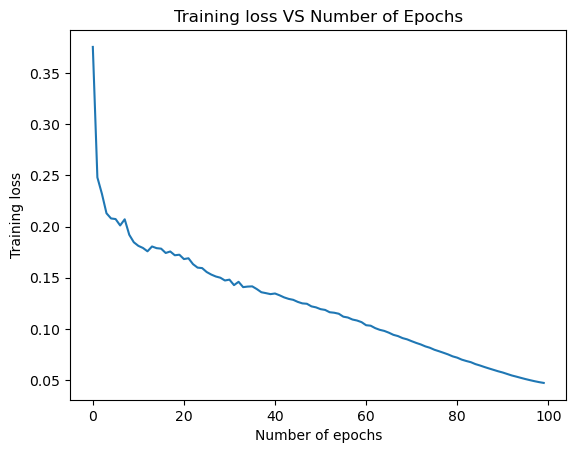

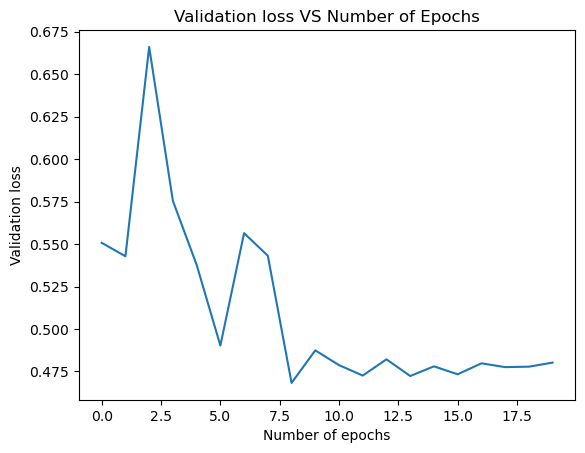

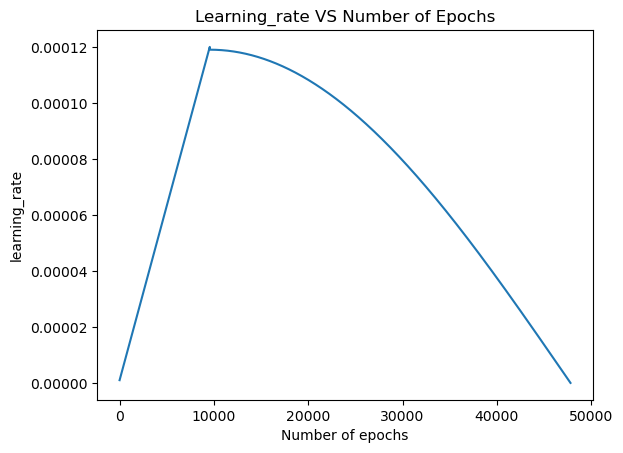

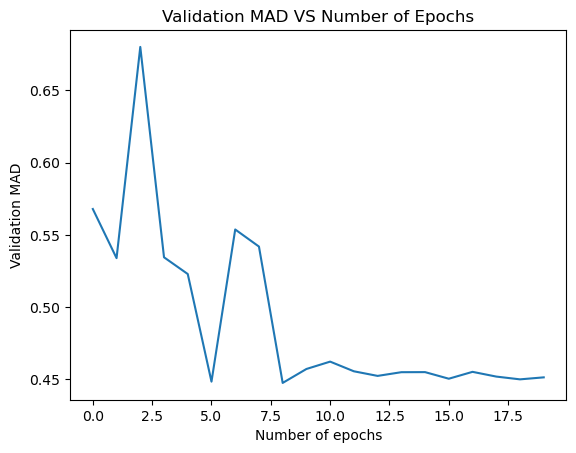

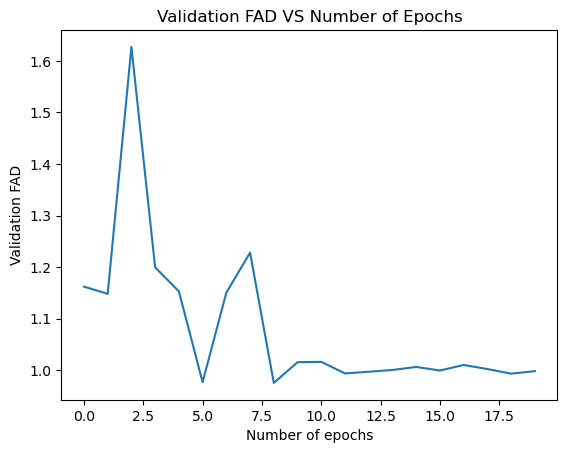

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'raw_cosine_sgd_epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_Transformer_modified.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting learning rate for model
plt.figure()
plt.plot(learning_rate)
plt.xlabel("Number of epochs")
plt.ylabel("learning_rate")
plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(val_mad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation MAD")
plt.title("Validation MAD VS Number of Epochs")

# plotting FAD
plt.figure()
plt.plot(val_fad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation FAD")
plt.title("Validation FAD VS Number of Epochs")

plt.show()

## 5. Visualisation

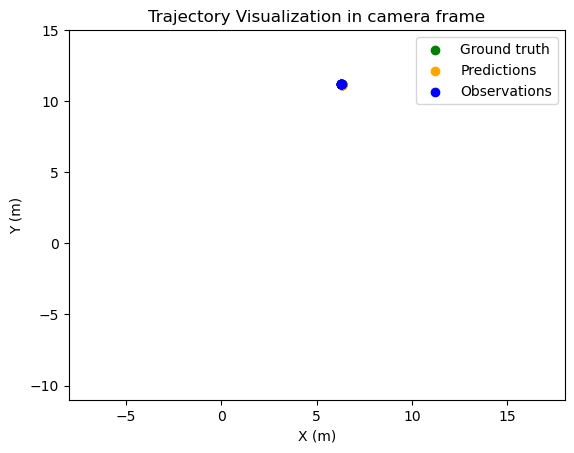

In [11]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # input to decoder
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
            1).repeat(val_input.shape[0], 1, 1).to(device)
        dec_inp = start_of_seq
        # decoder masks
        dec_source_mask = torch.ones(
            (val_input.shape[0], 1, val_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

        # prediction till horizon lenght
        for i in range(horizon):
            # getting model prediction
            # model_output = model_loaded.forward(
            #     val_input, dec_inp, dec_source_mask, dec_target_mask)

            model_output = model_loaded.forward(val_input, dec_inp)

            # appending the predicition to decoder input for next cycle
            dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

        # calculating loss using pairwise distance of all predictions
        val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                        contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(dec_inp[:, 1:, 2]))
        batch_val_loss += val_loss.item()

        # calculating the position for each time step of prediction based on velocity
        preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
            data['src'][:, -1:, 0:2].cpu().numpy()

        pr.append(preds_tr_b)
        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

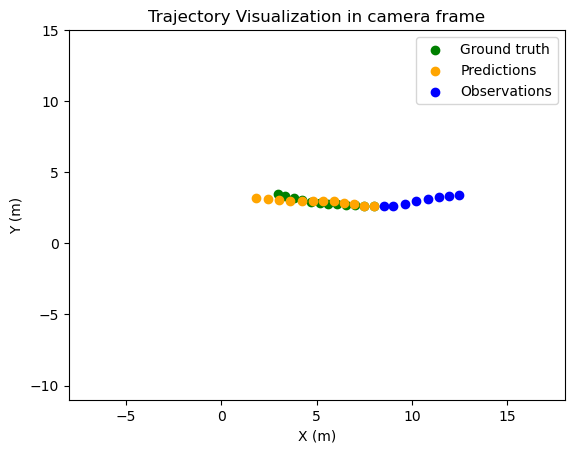

In [13]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
# plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set